# Forecasting COVID-19
In this notebook we show some preliminary results of forecasting the spread of the SARS-CoV-2 virus in China. We use a recurrent deep learning model to learn and predict the total number of cases in various provinces of China.

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
SEED = 42
import random
random.seed(SEED)
# Data reading
import csv
# File path manipulation
from os.path import join as pjoin
# Ordered dictionary data structure
from collections import OrderedDict
# Data manipulation and file loading
import pandas as pd
import numpy as np
np.random.seed(SEED)
# Plotting
import matplotlib.pyplot as plt
# Keras model and layers
import tensorflow as tf
tf.random.set_seed(SEED)
from keras.models import Model
from keras.layers import Dense, LSTM, Concatenate, Lambda, Input, Multiply
from keras.layers import Average
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
DATA_DIR = pjoin('.')

In [ ]:
!ls -la

total 24
drwxr-xr-x 1 root root 4096 Nov 28 21:14 .
drwxr-xr-x 1 root root 4096 Nov 28 21:13 ..
drwxr-xr-x 4 root root 4096 Nov 22 14:24 .config
-rw-r--r-- 1 root root 6343 Nov 28 21:14 europe.csv
drwxr-xr-x 1 root root 4096 Nov 22 14:27 sample_data


### Data Parsing
Here we read in the `Covid_ChinaM_raw.csv` CSV file - the first row contains the provinces in the country with corresponding populations and the second is a header with four attributes per province: 'Active', 'Total', 'Pop', 'Med'. We read the data into a `Pandas DataFrame` with a hierarchical index.

In [ ]:
# Read in the CSV
with open(pjoin(DATA_DIR, 'europe-3.csv'), 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    # First row of CSV contains country names and population information
    meta_row = next(csv_reader)
    # Data is four repeating headers per country: Active, Total, Pop, Med
    sub_header = next(csv_reader)[:4]
    # Read in each row as floats
    csv_data = [list(map(float, row)) for row in csv_reader]

# Dictionary mapping country name to population size (preserves order)
pop_dict = OrderedDict([
    (meta_row[i], float(meta_row[i + 1]))
    for i in range(0, len(meta_row), 2) if meta_row[i]
])
provinces = list(pop_dict.keys())
# A hierarchical index with the 4 attributes for each country
columns = pd.MultiIndex.from_product([provinces, sub_header],
                                     names=['country', 'feature'])
# Create a pandas dataframe and print some of the data
df = pd.DataFrame(csv_data, columns=columns, dtype=np.float32)
df.head()

country       germany                                       uk                \
feature        Active         Total    Pop   Med        Active         Total   
0        4.820000e-08  4.820000e-08  623.0  82.0  3.010000e-08  3.010000e-08   
1        4.820000e-08  4.820000e-08  623.0  82.0  3.010000e-08  3.010000e-08   
2        4.820000e-08  4.820000e-08  623.0  82.0  3.010000e-08  3.010000e-08   
3        8.440000e-08  8.440000e-08  623.0  82.0  3.010000e-08  3.010000e-08   
4        8.440000e-08  8.440000e-08  623.0  82.0  4.510000e-08  4.510000e-08   

country                      italy                             
feature    Pop   Med        Active         Total    Pop   Med  
0        709.0  30.0  3.290000e-08  3.290000e-08  485.0  36.0  
1        709.0  30.0  3.290000e-08  3.290000e-08  485.0  36.0  
2        709.0  30.0  3.290000e-08  3.290000e-08  485.0  36.0  
3        709.0  30.0  3.290000e-08  3.290000e-08  485.0  36.0  
4        709.0  30.0  3.290000e-08  3.290000e-08  485.0  36.0

In [ ]:
# Grab all the data of each attribute
data_act = df.loc(axis=1)[:, 'Active'].values
data_tot = df.loc(axis=1)[:, 'Total'].values
data_pop = df.loc(axis=1)[:, 'Pop'].values
data_med = df.loc(axis=1)[:, 'Med'].values

# Normalize the temporal data in the DataFrame (country-wise)
scaler_act = MinMaxScaler(feature_range=(0, 1))
scaler_tot = MinMaxScaler(feature_range=(0, 1))

data_act = scaler_act.fit_transform(data_act)
data_tot = scaler_tot.fit_transform(data_tot)

### Data Formatting
Here, we convert the data to sequences with a "look-back" parameter. This simply creates sequences of such a size that are fed to the model to learn to predict the next value. In this case, we use 5 days of data to predict the day directly proceeding.

In [ ]:
# Convert time-series into LSTM training set
def create_dataset(dataset, ns, look_back=1):
    x_data, y_data = [], []
    for c in ns:
        data_seq = dataset[:, c]
        for i in range(len(data_seq) - look_back):
            x_data.append(data_seq[i:(i + look_back)])
            y_data.append(data_seq[i + look_back])
    return np.asarray(x_data), np.asarray(y_data)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 5

indices = list(range(3))
train_active, target_active = create_dataset(data_act,
                                             indices,
                                             look_back)
train_total, target_total = create_dataset(data_tot,
                                           indices,
                                           look_back)
train_pop, target_pop = create_dataset(data_pop,
                                       indices,
                                       look_back)
train_med, target_med = create_dataset(data_med,
                                       indices,
                                       look_back)

# Manual minmax scale for population density and hospital density
max_pop = np.max(target_pop)
min_pop = np.min(train_pop)
train_pop = (train_pop - min_pop) / (max_pop - min_pop)
target_pop = (target_pop - min_pop) / (max_pop - min_pop)

max_med = np.max(target_med)
min_med = np.min(train_med)
train_med = (train_med - min_med) / (max_med - min_med)
target_med = (target_med - min_med) / (max_med - min_med)

In [ ]:
# Concatenate data together into final train data format
x_train = np.stack((train_active, train_total, train_pop, train_med),
                   axis=-1)
y_train = np.stack((target_active, target_total),
                   axis=-1)

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.0
    Uninstalling keras-3.0.0:
      Successfully uninstalled keras-3.0.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully un

### Model Definition
Here we define a custom small LSTM architecture that integrates two temporal inputs and combines the two static attributes.

In [ ]:
MODEL = 3  # The best-performing architecture without hyperparameter tuning

# create and fit the LSTM network
nf_time = 2  # number of features changing with time
nf_all = x_train.shape[-1]  # 4 total features

# Number of ensemble models (take average over all outputs)
N_ENSEMBLE = 3

all_inputs = Input(shape=(look_back, nf_all))
model_outputs = []
for i in range(N_ENSEMBLE):
    # The recurrent input
    rec_input = Lambda(
        lambda x: x[:, :, :nf_time],
        name='rec_in_' + str(i)
    )(all_inputs)
    # The LSTM
    h = LSTM(
        20, input_shape=(look_back, nf_time)
    )(rec_input)

    if MODEL == 1:  # Model 1
        use_dense2 = True
        split_feats = False
        merge_layer = Multiply
    elif MODEL == 2:  # Model 2
        use_dense2 = True
        split_feats = True
        merge_layer = Multiply
    elif MODEL == 3:  # Model 3
        use_dense2 = False
        split_feats = True
        merge_layer = Concatenate
    elif MODEL == 4:  # Model 4
        use_dense2 = True
        split_feats = False
        merge_layer = Concatenate
    elif MODEL == 5:  # Model 5
        use_dense2 = True
        split_feats = True
        merge_layer = Concatenate
    else:
        raise NotImplementedError(MODEL)

    # Input of the merge layer
    merge_input = Lambda(
        lambda x: x[:, 0, nf_time:] if split_feats else x[:, 0, :],
        name='merge_in_' + str(i)
    )(all_inputs)
    # Dense layer for input 0 before merge
    if use_dense2:
        merge_input = Dense(20, activation='softmax')(merge_input)
    # Merge the dense output with the recurrent output
    merged = merge_layer()([h, merge_input])
    # 2 outputs being predicted (active & total)
    out = Dense(2)(merged)
    model_outputs.append(out)

# Create the Keras Model and print a summary
CoVid = Model(inputs=all_inputs,
              outputs=Average()(model_outputs))
CoVid.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 4)]               0         []                            
                                                                                                  
 rec_in_0 (Lambda)           (None, 5, 2)                 0         ['input_1[0][0]']             
                                                                                                  
 rec_in_1 (Lambda)           (None, 5, 2)                 0         ['input_1[0][0]']             
                                                                                                  
 rec_in_2 (Lambda)           (None, 5, 2)                 0         ['input_1[0][0]']             
                                                                                              

### Model Visualization
If you have the `pydot` Python package installed, we can use Keras' `plot_model` utility to visualize the model layers and connectivity.

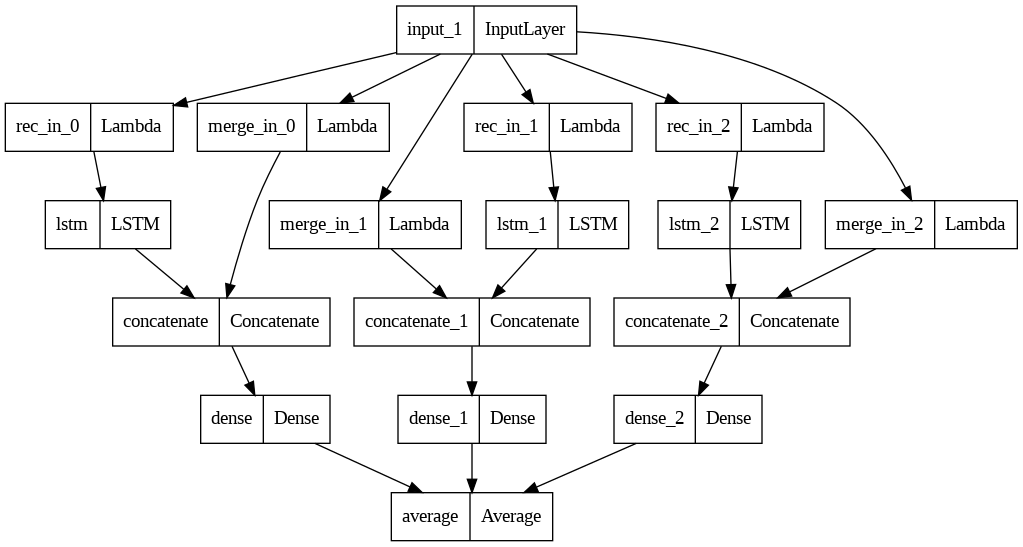

In [ ]:
from keras.utils import plot_model
plot_model(CoVid)

### Training
Now, we compile the model with the Mean-Squared-Error loss function and the Adam optimization algorithm based on gradient descent. We then fit the training data.

In [ ]:
CoVid.compile(loss='mean_squared_error', optimizer='adam')
_ = CoVid.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
3/3 - 7s - loss: 0.0582 - 7s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.0532 - 27ms/epoch - 9ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0494 - 39ms/epoch - 13ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0458 - 32ms/epoch - 11ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0431 - 29ms/epoch - 10ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0400 - 30ms/epoch - 10ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0381 - 31ms/epoch - 10ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0360 - 32ms/epoch - 11ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0343 - 33ms/epoch - 11ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0320 - 29ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0301 - 31ms/epoch - 10ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0284 - 31ms/epoch - 10ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0263 - 36ms/epoch - 12ms/step
Epoch 14/100
3/3 - 0s - loss: 0.0243 - 29ms/epoch - 10ms/step
Epoch 15/100
3/3 - 0s - loss: 0.0224 - 30ms/epoch - 10ms/step
Epoch 16/100
3/3 - 0s - loss: 0.0205 - 28ms/epoch - 9ms/step
Epoch 17/100
3/3 - 0s -

2/2 [==============================] - 4s 13ms/step - loss: 7.9051e-04
error: 0.0007905089878477156
2/2 [==============================] - 0s 8ms/step - loss: 7.9051e-04
Mean Squared Error: 0.0007905089878477156
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
error: 0.003394291503354907
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Mean Squared Error: 0.003394291503354907
2/2 [==============================] - 0s 9ms/step - loss: 0.0010
error: 0.0010035743471235037
2/2 [==============================] - 0s 8ms/step - loss: 0.0010
Mean Squared Error: 0.0010035743471235037


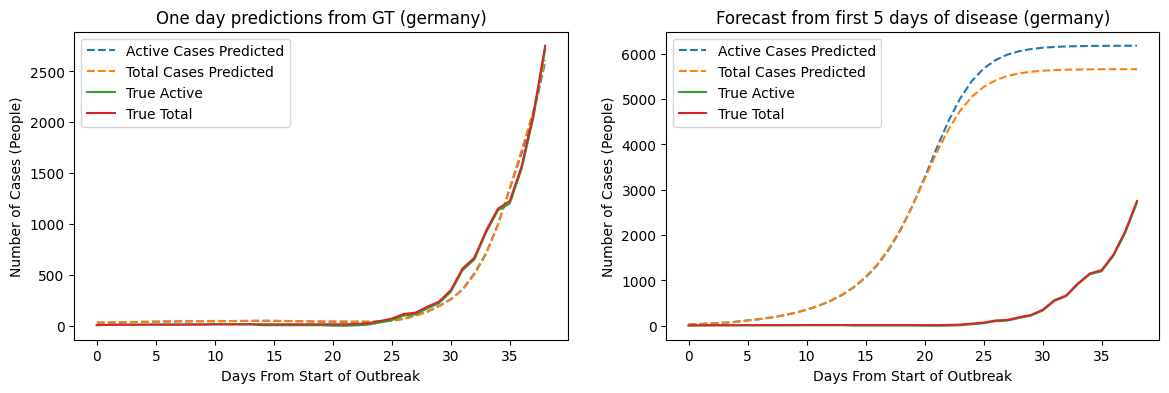

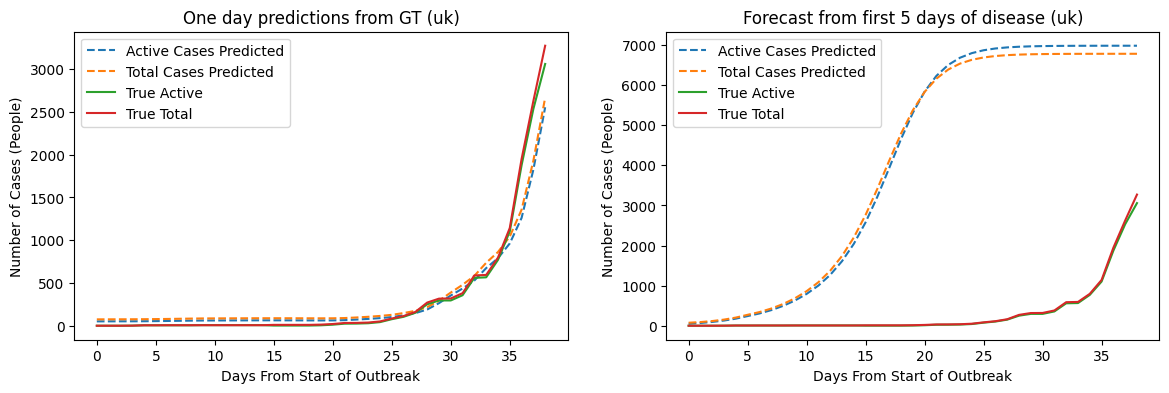

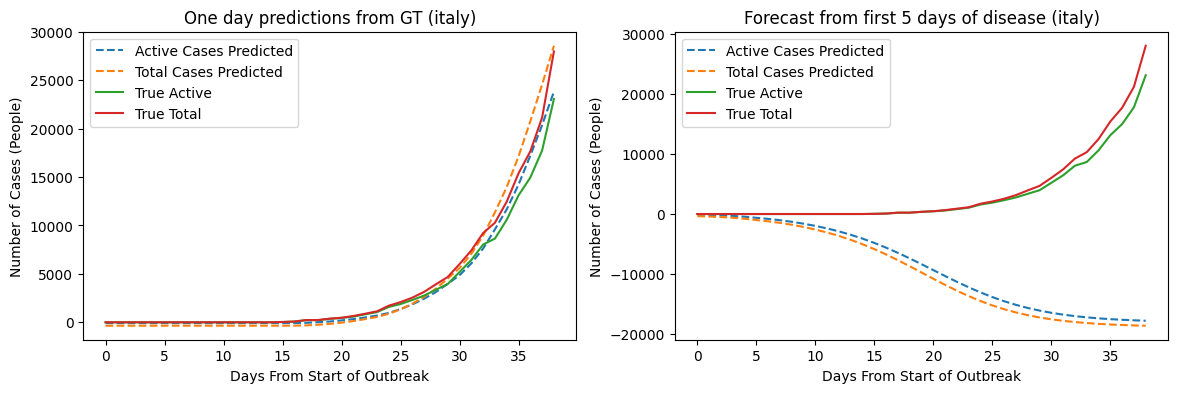

In [ ]:
# Values for transforming normalized data to number of people
popV = [82930000,66490000,60800000]
rangeA = scaler_act.data_range_
minA = scaler_act.data_min_
rangeT = scaler_tot.data_range_
minT = scaler_tot.data_min_

for r in [0,1,2]:
    # Create test data for specific region
    test_active, target_activeT = create_dataset(data_act, [r], look_back)
    test_total, target_totalT = create_dataset(data_tot, [r], look_back)
    test_pop, target_popT = create_dataset(data_pop, [r], look_back)
    test_med, target_medT = create_dataset(data_med, [r], look_back)

    # Scale population density and hospital density
    test_pop = (test_pop - min_pop) / (max_pop - min_pop)
    target_popT = (target_popT - min_pop) / (max_pop - min_pop)
    test_med = (test_med - min_med) / (max_med - min_med)
    target_medT = (target_medT - min_med) / (max_med - min_med)

    x_test = np.stack((test_active, test_total, test_pop, test_med),
                      axis=-1)
    y_test = np.stack((target_activeT, target_totalT),
                      axis=-1)

    # One-day predictions from test data
    test_predict = CoVid.predict(x_test)
    print('error:', CoVid.evaluate(x_test, y_test))

    # Set up initial data point for forecasting
    initX = x_test[0, :, :]
    initX = np.reshape(initX, (1, look_back, nf_all))

    # Place holder to store forecast values
    total_predict = np.zeros((1, x_test.shape[0]))
    active_predict = np.zeros((1, x_test.shape[0]))

    # Loop through duration of forecast
    for tp in range(len(test_active)):
        prevX = initX
        oi = prevX[0, 1:, :]
        # Predict next day's data points (active and total cases)
        single_predict = CoVid.predict(initX)

        # Reformat new data point to predict from
        ci = np.reshape(prevX[0, 0, nf_time:], (1, 2))
        complete_in = np.concatenate((single_predict, ci), axis=1)
        initX = np.concatenate((oi, complete_in), axis=0)
        initX = np.reshape(initX, (1, look_back, nf_all))

        # Store predictions
        total_predict[0, tp] = np.float32(single_predict[0][1])
        active_predict[0, tp] = np.float32(single_predict[0][0])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    # Plot one-day predictions from GT
    ax1.plot(((test_predict[:, 0] * rangeA[r]) + minA[r]) * popV[r],
             linestyle='dashed')
    ax1.plot(((test_predict[:, 1] * rangeT[r]) + minT[r]) * popV[r],
             linestyle='dashed')
    ax1.plot(((y_test[:, 0] * rangeA[r]) + minA[r]) * popV[r])
    ax1.plot(((y_test[:, 1] * rangeT[r]) + minT[r]) * popV[r])

    ax1.set_xlabel('Days From Start of Outbreak')
    ax1.set_ylabel('Number of Cases (People)')
    ax1.set_title('One day predictions from GT ({})'.format(provinces[r]))
    ax1.legend(['Active Cases Predicted', 'Total Cases Predicted',
                'True Active', 'True Total'])

    # Plot forecast spread from initial data
    ax2.plot(((active_predict[0, :] * rangeA[r]) + minA[r]) * popV[r],
             linestyle='dashed')
    ax2.plot(((total_predict[0, :] * rangeT[r]) + minT[r]) * popV[r],
             linestyle='dashed')
    ax2.plot(((y_test[:, 0] * rangeA[r]) + minA[r]) * popV[r])
    ax2.plot(((y_test[:, 1] * rangeT[r]) + minT[r]) * popV[r])

    ax2.set_xlabel('Days From Start of Outbreak')
    ax2.set_ylabel('Number of Cases (People)')
    ax2.set_title('Forecast from first 5 days of disease '
                  '({})'.format(provinces[r]))
    ax2.legend(['Active Cases Predicted', 'Total Cases Predicted',
                'True Active', 'True Total'])
    # print the MSE
    mse = CoVid.evaluate(x_test, y_test)
    print('Mean Squared Error:', mse)
plt.show()